https://github.com/oya163/bert-llm/blob/master/CyberSecurityNER/cyber_security_ner.ipynb

https://huggingface.co/Jean-Baptiste/camembert-ner-with-dates?text=Je+m%27appelle+jean-baptiste+et+j%27habite+%C3%A0+montr%C3%A9al+depuis+fevr+2012+Je+travaille+chez+Microsoft+je+gagne+10000+euros+par+an

# Load modules

In [2]:
from sklearn.preprocessing import LabelEncoder
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoTokenizer
from transformers import AutoModelForTokenClassification, pipeline, DataCollatorForTokenClassification

import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import evaluate
from datasets import Dataset
import matplotlib.pyplot as plt

# from seqeval.metrics import classification_report

/home/charlie/.pyenv/versions/3.10.6/envs/tata_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-09 18:25:33.105427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 18:25:33.105525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 18:25:33.187431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 18:25:33.338656: I tensorflow/core/platform/cpu_feature_guard.cc:182]

In [3]:
path ='/mnt/c/Users/utilisateur/E2_tata/data/cleaned_raw_bbox_df.csv'
df=pd.read_csv(path)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,B-company
4,X00016469612,2,TA,I-company


In [5]:
entity_list=df['entity'].unique().tolist()
entity_list

['O',
 'B-company',
 'I-company',
 'B-address',
 'I-address',
 'B-date',
 'B-total',
 'I-date']

In [6]:
entity_list=df['entity'].unique().tolist()
new_entity_list=['O','I-ORG','I-ORG','I-LOC','I-LOC','I-DATE','I-MISC','I-DATE']

df['entity']=df['entity'].replace(entity_list, new_entity_list)
df.head()

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,I-ORG
4,X00016469612,2,TA,I-ORG


In [7]:
df['entity'].unique().tolist()

['O', 'I-ORG', 'I-LOC', 'I-DATE', 'I-MISC']

In [8]:
label_list = ['O','I-ORG','I-LOC','I-DATE','I-MISC']
df['sentence_id'] = df['doc'] + df['line_id'].astype(str)
df["sentence_id"] = LabelEncoder().fit_transform(df["sentence_id"] )
ner_tag = list(range(0,5))
df['ner_tag']=df['entity'].replace(label_list, ner_tag)

In [9]:
df['doc']=df['doc'].astype(str)
df['sentence_id']=df['sentence_id'].astype(int)
df['tokens']=df['value'].astype(str)
df['ner_tags']=df['ner_tag'].astype(int)
df['labels']=df['entity'].astype(str)

df=df[["sentence_id", "tokens", "labels", "ner_tags"]]

df.head()

,sentence_id,tokens,labels,ner_tags
0,0,TAN,O,0
1,0,WOON,O,0
2,0,YANN,O,0
3,11,BOOK,I-ORG,1
4,11,TA,I-ORG,1


In [10]:
# Réorganiser les données
df = df.groupby('sentence_id').agg({
    'tokens': list,
    'labels': list,
    'ner_tags': list,
}).reset_index()

# Renommer la colonne id
df.rename(columns={'id': 'sentence_id'}, inplace=True)
df.head()

,sentence_id,tokens,labels,ner_tags
0,0,"[TAN, WOON, YANN]","[O, O, O]","[0, 0, 0]"
1,1,"[25/12/2018, 8:13:39, PM]","[I-DATE, O, O]","[3, 0, 0]"
2,2,[CASHIER:],[O],[0]
3,3,[MANIS],[O],[0]
4,4,[MEMBER:],[O],[0]


# 01 Load my data

# Split

In [10]:
# from ast import literal_eval
# # Réorganiser les données
# df['sentence_id']=df['sentence_id'].astype(int)

# # Supposons que df est votre DataFrame
# # Convertir les chaînes qui représentent des listes en véritables listes Python
# df['tokens'] = df['tokens'].apply(literal_eval)
# df['labels'] = df['labels'].apply(literal_eval)
# df['ner_tags'] = df['ner_tags'].apply(literal_eval)


In [11]:
# df

In [11]:
train_df, test_val_df = train_test_split(df, test_size=0.3)
test_df, eval_df = train_test_split(test_val_df, test_size=0.5)

In [12]:
test_df

,sentence_id,tokens,labels,ner_tags
39829,39829,[DISCOUNT],[O],[0]
7176,7176,"[MODERN, DEPOT, SDN, BHD]","[I-ORG, I-ORG, I-ORG, I-ORG]","[1, 1, 1, 1]"
32477,32477,"[KEEP, THE, INVOICE, FOR, APPLICABLE, RETURNS]","[O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0]"
43953,43953,[(1113440A)],[O],[0]
22958,22958,[42901],[O],[0]
...,...,...,...,...
34523,34523,"[002-2016/05/01, 14:13:10]","[O, O]","[0, 0]"
49010,49010,"[TAX, (RM)]","[O, O]","[0, 0]"
44470,44470,[19:47:00],[O],[0]
5352,5352,[ZRL],[O],[0]


In [13]:
# En supposant que train_df est un DataFrame pandas avec les colonnes "words" et "ner_tags"
train_dataset = Dataset.from_pandas(train_df)
test_dataset=Dataset.from_pandas(test_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [15]:
train_dataset[0]

{'sentence_id': 7339,
 'tokens': ['4', '178104', '00', 'vs', '5', 'rl'],
 'labels': ['O', 'O', 'O', 'O', 'O', 'O'],
 'ner_tags': [0, 0, 0, 0, 0, 0],
 '__index_level_0__': 7339}

In [16]:
train_dataset[25]

{'sentence_id': 1715,
 'tokens': ['2x', 'hey', 'song'],
 'labels': ['O', 'O', 'O'],
 'ner_tags': [0, 0, 0],
 '__index_level_0__': 1715}

In [17]:
train_dataset[50]

{'sentence_id': 5851,
 'tokens': ['mr', 'd1', 'kuchai', 'son', 'bho'],
 'labels': ['I-ORG', 'O', 'I-ORG', 'O', 'O'],
 'ner_tags': [1, 0, 1, 0, 0],
 '__index_level_0__': 5851}

In [18]:
eval_dataset[0]

{'sentence_id': 11193,
 'tokens': ['aga', '7t9bp', 'sin', '729', '1x', 'ts', 'ieee'],
 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'O'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0],
 '__index_level_0__': 11193}

In [19]:
test_dataset[100]

{'sentence_id': 4769,
 'tokens': ['cash', 'rm', '15000'],
 'labels': ['O', 'O', 'O'],
 'ner_tags': [0, 0, 0],
 '__index_level_0__': 4769}

In [20]:
test_dataset[103]

{'sentence_id': 16505,
 'tokens': ['10', 'srv', 'chg', '198'],
 'labels': ['O', 'O', 'O', 'O'],
 'ner_tags': [0, 0, 0, 0],
 '__index_level_0__': 16505}

# Tokenization

In [14]:
# model_checkpoint ="dslim/bert-base-NER"
# model_checkpoint ="bert-base-uncased"
model_checkpoint='Jean-Baptiste/camembert-ner-with-dates'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

originaux

In [15]:
#  Align the number of labels and the tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [17]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [18]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_train = train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map:   0%|          | 0/35123 [00:00<?, ? examples/s]

Map: 100%|██████████| 35123/35123 [00:01<00:00, 32830.41 examples/s]


In [19]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_eval = eval_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map: 100%|██████████| 7527/7527 [00:00<00:00, 24101.77 examples/s]


In [20]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_test= test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map:   0%|          | 0/7526 [00:00<?, ? examples/s]

Map: 100%|██████████| 7526/7526 [00:00<00:00, 28558.83 examples/s]


# Fine Tuning

## Data Collator

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Setup Evaluation

In [22]:
new_entity_list=['O','I-LOC','I-PER', 'I-MISC','I-ORG', 'I-DATE']

In [23]:
metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[new_entity_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [new_entity_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [24]:
id2label = {i: label for i, label in enumerate(new_entity_list)}
label2id = {v: k for k, v in id2label.items()}

In [25]:
id2label

{0: 'O', 1: 'I-LOC', 2: 'I-PER', 3: 'I-MISC', 4: 'I-ORG', 5: 'I-DATE'}

In [26]:
label2id

{'O': 0, 'I-LOC': 1, 'I-PER': 2, 'I-MISC': 3, 'I-ORG': 4, 'I-DATE': 5}

# freez layers

In [27]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
# Geler tous les paramètres du modèle
for param in model.parameters():
    param.requires_grad = False

# Identifier les indices des dernières couches BertLayer que vous souhaitez fine-tuner
# Exemple : fine-tuner les deux dernières couches de BertEncoder
layers_to_finetune = [len(model.roberta.encoder.layer) - 1, len(model.roberta.encoder.layer) - 1]

# Dé-geler les paramètres des couches spécifiées
for i in layers_to_finetune:
    for param in model.roberta.encoder.layer[i].parameters():
        param.requires_grad = True

In [28]:
layers_to_finetune


[11, 11]

In [29]:
model.config

CamembertConfig {
  "_name_or_path": "Jean-Baptiste/camembert-ner-with-dates",
  "architectures": [
    "CamembertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "I-LOC",
    "2": "I-PER",
    "3": "I-MISC",
    "4": "I-ORG",
    "5": "I-DATE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "I-DATE": 5,
    "I-LOC": 1,
    "I-MISC": 3,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 3200

In [30]:
model.config.num_labels

6

# Look at tokenized dictionnary

In [37]:
tokenized_datasets_train

Dataset({
    features: ['sentence_id', 'tokens', 'labels', 'ner_tags', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 12735
})

In [38]:
tokenized_datasets_eval

Dataset({
    features: ['sentence_id', 'tokens', 'labels', 'ner_tags', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2730
})

In [39]:
tokenized_datasets_train[0]

{'sentence_id': 7339,
 'tokens': ['4', '178104', '00', 'vs', '5', 'rl'],
 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100],
 'ner_tags': [0, 0, 0, 0, 0, 0],
 '__index_level_0__': 7339,
 'input_ids': [5, 181, 458, 6893, 3225, 6701, 9908, 205, 874, 219, 6],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
tokenized_datasets_train[2]

{'sentence_id': 9877,
 'tokens': ['os'],
 'labels': [-100, 0, -100],
 'ner_tags': [0],
 '__index_level_0__': 9877,
 'input_ids': [5, 4800, 6],
 'attention_mask': [1, 1, 1]}

In [41]:
tokenized_datasets_eval[2]

{'sentence_id': 15717,
 'tokens': ['ac'],
 'labels': [-100, 0, -100],
 'ner_tags': [0],
 '__index_level_0__': 15717,
 'input_ids': [5, 5720, 6],
 'attention_mask': [1, 1, 1]}

# Training

optimizers : https://huggingface.co/docs/transformers/v4.37.2/en/main_classes/trainer#transformers.TrainingArguments

In [31]:
args = TrainingArguments(
    "bert-finetuned-ner-11",
    evaluation_strategy="epoch",
    learning_rate=7e-6,
    num_train_epochs=30,
    weight_decay=0.02,
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    save_strategy="epoch",
    # optim='adafactor',
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)],

)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.296500,0.258891,0.395349,0.189163,0.255890,0.914294
2,0.259100,0.244793,0.628410,0.323174,0.426837,0.928506
3,0.196400,0.203674,0.657588,0.408805,0.504177,0.937014
4,0.190700,0.185499,0.734292,0.469279,0.572609,0.943936
5,0.186900,0.167801,0.714105,0.546202,0.618969,0.947132
6,0.157100,0.155955,0.753477,0.576681,0.653330,0.951824
7,0.165000,0.143758,0.778788,0.621674,0.691418,0.955733
8,0.160300,0.139849,0.811991,0.674891,0.737120,0.957757
9,0.149500,0.141756,0.842371,0.646347,0.731454,0.957274
10,0.154100,0.130431,0.824069,0.695694,0.754460,0.960079


/home/charlie/.pyenv/versions/3.10.6/envs/tata_env/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=87820, training_loss=0.169805510791769, metrics={'train_runtime': 5219.5267, 'train_samples_per_second': 201.875, 'train_steps_per_second': 25.238, 'total_flos': 5558163164424612.0, 'train_loss': 0.169805510791769, 'epoch': 20.0})

# Graphic representation

## Confusion matrix

In [52]:
# Obtenir les prédictions
predictions, labels, _ = trainer.predict(tokenized_datasets_test)
predictions = np.argmax(predictions, axis=2)

Text(0.5, 1.0, 'Confusion Matrix après entrainnement 10')

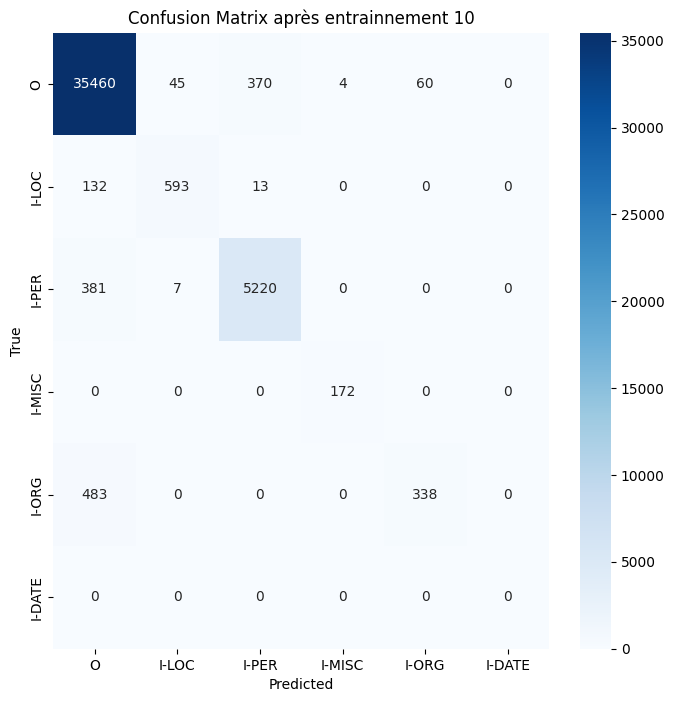

In [53]:
# Aplatir les listes
true_labels = []
pred_labels = []
for i, label in enumerate(labels):
    for j, label_id in enumerate(label):
        if label_id != -100:  # Ignorer les tokens spéciaux
            true_labels.append(label_id)
            pred_labels.append(predictions[i][j])

# Convertir les indices en étiquettes textuelles (selon votre mapping d'indices)
# Vous devez définir `id2label` basé sur votre modèle ou votre Tokenizer
true_label_text = [id2label[id] for id in true_labels]
pred_label_text = [id2label[id] for id in pred_labels]

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_label_text, pred_label_text, labels=list(id2label.values()))

# Sauvegarder le graphique Seaborn dans un fichier image (par exemple, PNG)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=new_entity_list, yticklabels=new_entity_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix après entrainnement 10')

## Loss and Accuracy

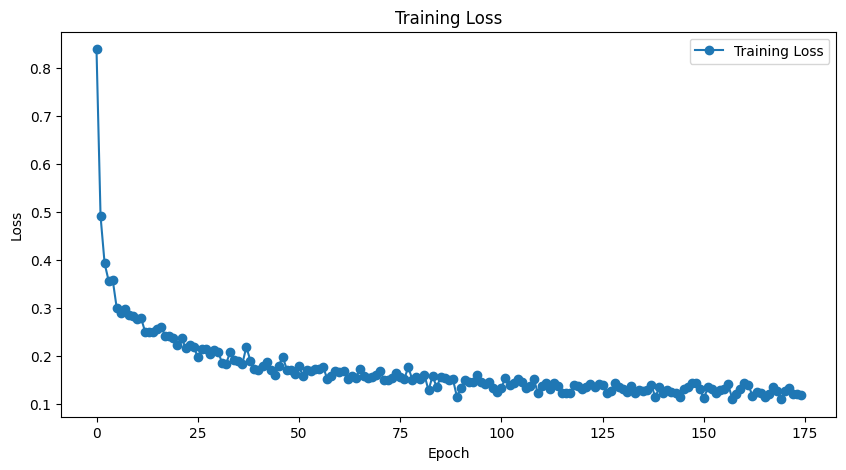

In [35]:
# Récupération des métriques d'entraînement
train_metrics = trainer.state.log_history

# Extraction des métriques spécifiques que vous souhaitez tracer (par exemple, la perte)
train_loss = [metric['loss'] for metric in train_metrics if 'loss' in metric]
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
eval_losses = []
eval_accuracies = []

for log in trainer.state.log_history:
    if 'eval_loss' in log and 'step' in log:  # Métriques d'entraînement
        eval_losses.append(log['eval_loss'])

    if 'eval_accuracy' in log:  # Score F1 d'évaluation
        eval_accuracies.append(log['eval_accuracy'])

# Affichage des métriques récupérées
print("eval_losses", eval_losses)
print("eval_accuracies:", eval_accuracies)

eval_losses [0.2588905096054077, 0.2447931468486786, 0.20367392897605896, 0.1854986995458603, 0.1678014099597931, 0.15595509111881256, 0.14375753700733185, 0.139849454164505, 0.1417558640241623, 0.1304313689470291, 0.1275978535413742, 0.1316736787557602, 0.12148836255073547, 0.12128768116235733, 0.11837461590766907, 0.12174849212169647, 0.12018397450447083, 0.12200003862380981, 0.11272842437028885, 0.11515157669782639]
eval_accuracies: [0.9142942556224992, 0.9285057259807754, 0.9370142114703582, 0.9439359793956675, 0.9471324104309433, 0.9518235754035782, 0.9557328795474406, 0.9577565193395575, 0.9572736052982569, 0.9600791059191464, 0.9602860690797038, 0.9621027457112634, 0.9648852504254243, 0.9658970703214828, 0.9664719679896978, 0.96594306213494, 0.9666559352435267, 0.9661960171089546, 0.968426620061629, 0.9685415995952721]


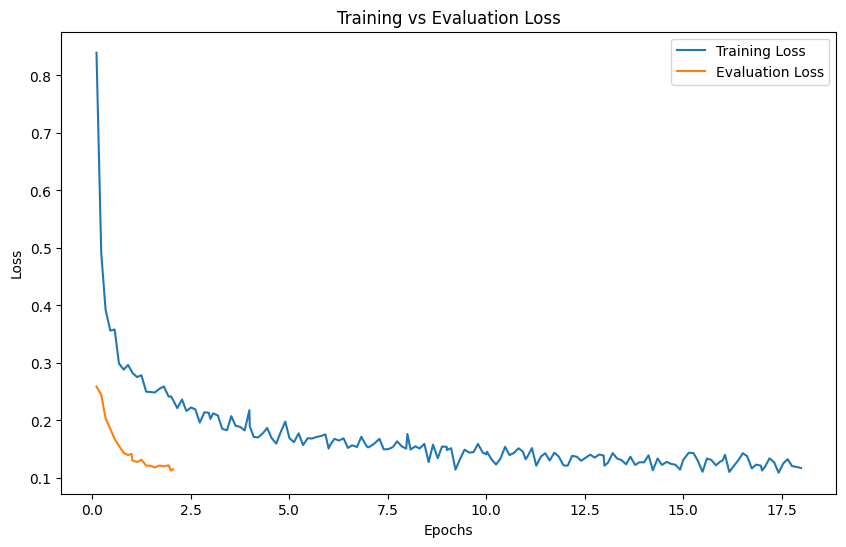

In [37]:
train_loss = [entry["loss"] for entry in train_metrics if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in train_metrics if "eval_loss" in entry]
epochs = [entry["epoch"] for entry in train_metrics if "loss" in entry or "eval_loss" in entry]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.show()

# Save the model

In [38]:
saved_model_path='custom_model-11'
trainer.save_model(saved_model_path)

# Evaluate

In [39]:
predictions = trainer.predict(tokenized_datasets_eval)

In [40]:
from tabulate import tabulate

metrics = ['precision', 'recall', 'f1', 'accuracy']
prediction_results = []

for key, val in predictions.metrics.items():
    if any(item in key for item in metrics):
        prediction_results.append([key, str(round(val,4)*100)+'%'])

print(tabulate(prediction_results, headers=['Metric', 'Score']))

Metric          Score
--------------  ------------------
test_precision  86.72999999999999%
test_recall     77.46%
test_f1         81.83%
test_accuracy   96.85000000000001%


# Inference

In [41]:
inference= """MR. D.I.¥. (KUCHAT) SDN BHD
CO-REG:750441-W
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000473792512)
(TESCO EXTRA KAJANG)
-TAX INVOICE-

BOOSTER CABLE XH-500A +*§
CE72 - 10
9001620 1X 29.90 298,90
MOTH BALLS 1506 *§
EC21-41-71 - 10/100
9063977 1X 2,10 2,10
DIY GOLD TWIST DRILL 3MM *§
LB22 - 20/1500
9071246 1X 2,50 2,50
HSS TWIST DRILL 6*160MM *§
LG32-42 - 10/400
6909906163107 1X 3.30 3,30

Item(s) : 4 Qty(s) : 4
TOTAL INCL. GSTe6K RM 37.80
CASH RM 40.00
CHANGE RM 2.20

GST Summary Amt(RM) = Tax(RM)
GST S@6% 35.66 2.14

08-03-17 13:42 SHO1 BO28 = 12 000017473
OPERATOR TRAINEE

EXCHANGE ARE ALLOWED WITHIN
7 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND.



ee are can"""

In [42]:
token_classifier = pipeline(
    "token-classification", model=saved_model_path, aggregation_strategy="simple"
)
results = token_classifier(inference)

In [43]:
prediction_results = []
for each_entity in results:
    prediction_results.append([each_entity['word'], each_entity['entity_group']])

print(tabulate(prediction_results, headers=['Word', 'Predictions']))

Word                                                                                                                                          Predictions
--------------------------------------------------------------------------------------------------------------------------------------------  -------------
MR. D.I.¥. (KUCHAT) SDN BHD CO-REG:750441-W LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR  PER
TRA KAJANG                                                                                                                                    PER
A                                                                                                                                             PER
§ CE72                                                                                                                                        PER
B                                                                                                         